# Mental Health Survey CRISP-DM Notebook

Use this notebook on Colab or locally to run the full pipeline: data download, EDA, preprocessing, clustering, outlier detection, and happiness regression.

**Checklist before running:**
- Upload the Kaggle dataset CSV to a path you set in `DATA_PATH` or configure the Kaggle API cell.
- Ensure runtime has Python 3.10+.
- If running locally, `pip install -r requirements.txt` first.


In [1]:
# Optional: install dependencies on Colab (safe to skip if already installed)
!pip -q install -r "requirements.txt" || echo "Install locally as needed"


zsh:1: command not found: pip
Install locally as needed


In [2]:
import json
import os
import pathlib
import random
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


## Configure data location
- Set `DATA_PATH` to your Kaggle CSV.
- Optional: uncomment the Kaggle API cell if you want to download programmatically.


In [3]:
# Path to the mental health CSV (update this for your environment)
DATA_PATH = pathlib.Path("./Mental_Health_and_Social_Media_Balance_Dataset.csv")
TARGET_COL = "Happiness_Index(1-10)"  # target present in the provided dataset

# Example: configure Kaggle API if running on Colab (requires kaggle.json upload)
# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi(); api.authenticate()
# api.dataset_download_files("USERNAME/DATASET-NAME", path="./data", unzip=True)
# DATA_PATH = pathlib.Path("./data/your_file.csv")


In [4]:
# Load data
assert DATA_PATH.exists(), f"CSV not found at {DATA_PATH}. Please update DATA_PATH."
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(500, 10)


,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
0,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook,10.0
1,U002,30,Other,5.1,7.0,8.0,5.0,3.0,LinkedIn,10.0
2,U003,23,Other,7.4,6.0,7.0,1.0,3.0,YouTube,6.0
3,U004,36,Female,5.7,7.0,8.0,1.0,1.0,TikTok,8.0
4,U005,34,Female,7.0,4.0,7.0,5.0,1.0,X (Twitter),8.0


In [5]:
# Quick info
display(df.dtypes)
display(df.describe(include="all"))

def missingness_table(frame: pd.DataFrame) -> pd.DataFrame:
    miss_pct = frame.isna().mean().sort_values(ascending=False) * 100
    return miss_pct.to_frame(name="missing_pct").query("missing_pct > 0")

missingness_table(df).head(20)


User_ID                       object
Age                            int64
Gender                        object
Daily_Screen_Time(hrs)       float64
Sleep_Quality(1-10)          float64
Stress_Level(1-10)           float64
Days_Without_Social_Media    float64
Exercise_Frequency(week)     float64
Social_Media_Platform         object
Happiness_Index(1-10)        float64
dtype: object

,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
count,500,500.000000,500,500.000000,500.000000,500.000000,500.000000,500.000000,500,500.000000
unique,500,NaN,3,NaN,NaN,NaN,NaN,NaN,6,NaN
top,U001,NaN,Male,NaN,NaN,NaN,NaN,NaN,TikTok,NaN
freq,1,NaN,248,NaN,NaN,NaN,NaN,NaN,95,NaN
mean,NaN,32.988000,NaN,5.530000,6.304000,6.618000,3.134000,2.448000,NaN,8.376000
std,NaN,9.960637,NaN,1.734877,1.529792,1.542996,1.858751,1.428067,NaN,1.524228
min,NaN,16.000000,NaN,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,4.000000
25%,NaN,24.000000,NaN,4.300000,5.000000,6.000000,2.000000,1.000000,NaN,7.000000
50%,NaN,34.000000,NaN,5.600000,6.000000,7.000000,3.000000,2.000000,NaN,9.000000
75%,NaN,41.000000,NaN,6.700000,7.000000,8.000000,5.000000,3.000000,NaN,10.000000


,missing_pct


## Column typing
- Update `CAT_COLS` and `NUM_COLS` if you want to override the automatic detection.
- The target column is removed from predictors automatically.


In [6]:
# Manually set these if auto-detection is not correct for your dataset
CAT_COLS: List[str] = []
NUM_COLS: List[str] = []

def auto_columns(frame: pd.DataFrame, target: str) -> Dict[str, List[str]]:
    cat = frame.select_dtypes(include=["object", "category", "bool"])
    num = frame.select_dtypes(include=["number"]).copy()
    cat_cols = [c for c in cat.columns if c != target]
    num_cols = [c for c in num.columns if c != target]
    return {"cat": cat_cols, "num": num_cols}

if not CAT_COLS and not NUM_COLS:
    columns = auto_columns(df, TARGET_COL)
    CAT_COLS, NUM_COLS = columns["cat"], columns["num"]

FEATURE_COLS = CAT_COLS + NUM_COLS
print("Categorical: ", CAT_COLS)
print("Numeric: ", NUM_COLS)
assert TARGET_COL in df.columns, "Target column not found. Update TARGET_COL."


Categorical:  ['User_ID', 'Gender', 'Social_Media_Platform']
Numeric:  ['Age', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)', 'Days_Without_Social_Media', 'Exercise_Frequency(week)']


## EDA: distributions and correlations
- Run a small set of plots to understand distributions.


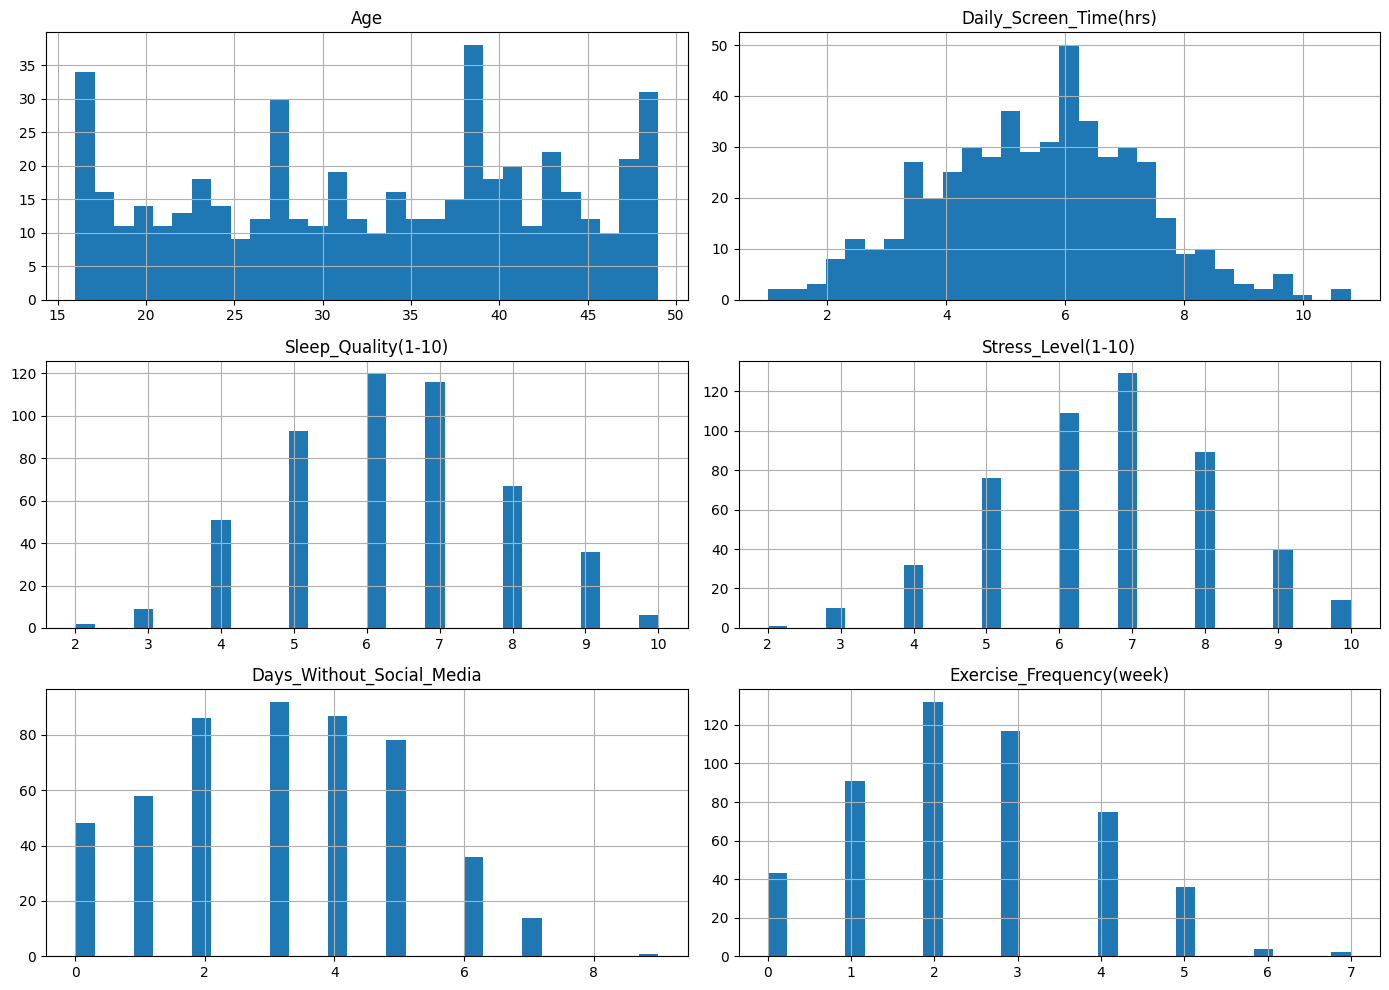

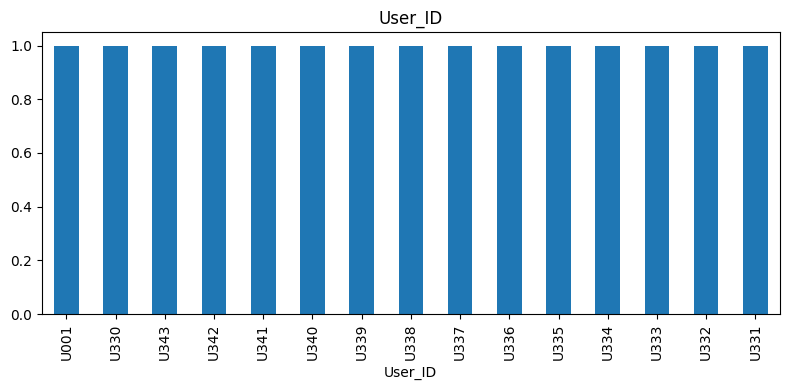

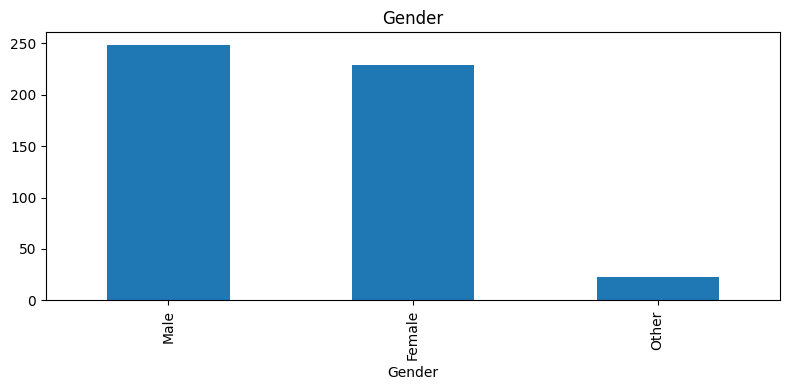

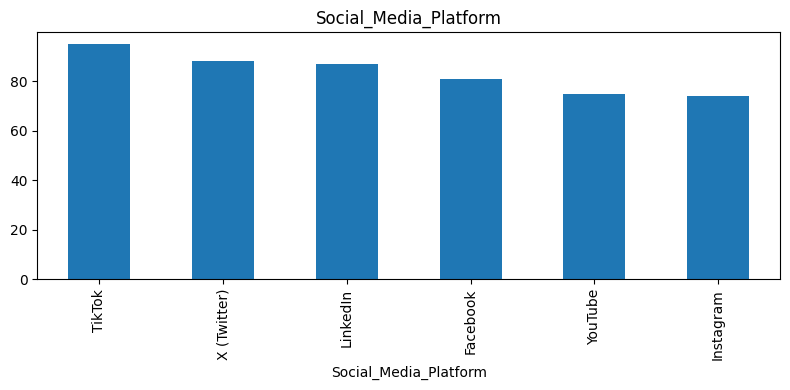

In [7]:
# Numeric distributions
num_sample = df[NUM_COLS].sample(min(len(df), 5000), random_state=RANDOM_STATE)
num_sample.hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()

# Categorical distributions (top 15 categories)
for col in CAT_COLS[:8]:
    plt.figure(figsize=(8, 4))
    df[col].value_counts(dropna=False).head(15).plot(kind="bar")
    plt.title(col)
    plt.tight_layout()
    plt.show()


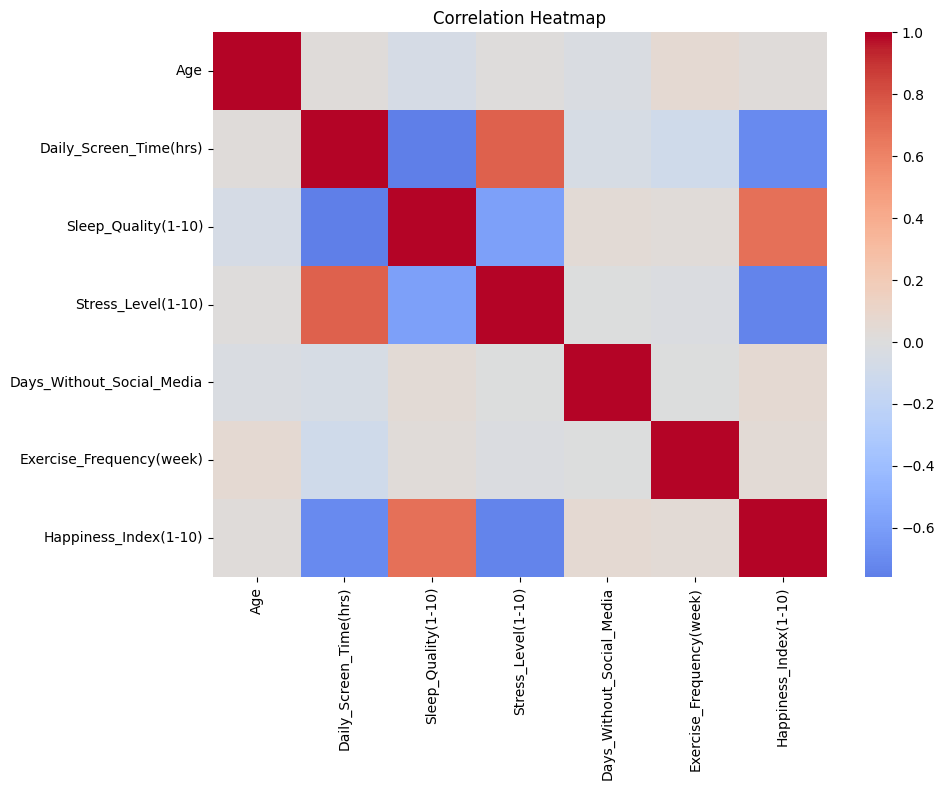

In [8]:
# Correlation heatmap for numeric features
if NUM_COLS:
    corr = df[NUM_COLS + [TARGET_COL]].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()


## Train/validation/test split and preprocessing
- Uses 70/15/15 split with simple imputers, one-hot encoding, and scaling.


In [9]:
X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].copy()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, CAT_COLS),
        ("numeric", numeric_transformer, NUM_COLS),
    ]
)


## Model training and validation
- Baseline and lightweight models compared using MAE, RMSE, R^2 on the validation set.


In [10]:
def regression_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred) ** 0.5,
        "r2": r2_score(y_true, y_pred),
    }

models = {
    "dummy_mean": DummyRegressor(strategy="mean"),
    "linear": LinearRegression(),
    "ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "lasso": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=5000),
    "rf": RandomForestRegressor(
        n_estimators=200, max_depth=8, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "gbr": GradientBoostingRegressor(random_state=RANDOM_STATE),
}

results = []
trained_models = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    metrics = regression_metrics(y_val, preds)
    row = {"model": name, **metrics}
    results.append(row)
    trained_models[name] = pipe

results_df = pd.DataFrame(results).sort_values("mae")
results_df


,model,mae,rmse,r2
4,rf,0.738248,0.934470,0.591556
5,gbr,0.756654,0.923955,0.600697
2,ridge,0.788391,0.947445,0.580135
1,linear,0.788730,0.948199,0.579467
3,lasso,0.790258,0.959624,0.569272
0,dummy_mean,1.273029,1.473447,-0.015477


In [11]:
# Evaluate the best model on the held-out test set
best_model_name = results_df.iloc[0]["model"]
best_model = trained_models[best_model_name]
test_preds = best_model.predict(X_test)
test_metrics = regression_metrics(y_test, test_preds)
print(f"Best model: {best_model_name}")
print(json.dumps(test_metrics, indent=2))


Best model: rf
{
  "mae": 0.7547290062984864,
  "rmse": 0.9640714716470087,
  "r2": 0.6534492152495417
}


In [12]:
# Permutation importance on validation data for the best model
perm = permutation_importance(
    best_model, X_val, y_val, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1
)

# Align names to original feature columns (permutation_importance permutes original X)
feature_names = FEATURE_COLS

importance_df = pd.DataFrame(
    {
        "feature": feature_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std,
    }
).sort_values("importance_mean", ascending=False)

importance_df.head(20)


,feature,importance_mean,importance_std
6,Stress_Level(1-10),3.297943e-01,3.362929e-02
4,Daily_Screen_Time(hrs),1.555730e-01,5.934154e-02
5,Sleep_Quality(1-10),1.157953e-01,2.682484e-02
0,User_ID,6.661338e-17,5.438960e-17
8,Exercise_Frequency(week),-7.809065e-04,3.422351e-03
7,Days_Without_Social_Media,-8.493353e-04,7.967654e-03
1,Gender,-1.593719e-03,4.062982e-03
3,Age,-4.022055e-03,5.288298e-03
2,Social_Media_Platform,-9.714883e-03,7.093983e-03


## Clustering (k-means) for respondent segments
- Uses scaled numeric features; categorical columns are one-hot encoded.


In [13]:
# Build a numeric-only view for clustering
numeric_view = df[NUM_COLS].copy()
numeric_view = numeric_view.fillna(numeric_view.median())
scaled_numeric = StandardScaler().fit_transform(numeric_view)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(scaled_numeric)
df_clusters = df.copy()
df_clusters["cluster"] = clusters

cluster_summary = df_clusters.groupby("cluster").agg({
    TARGET_COL: ["mean", "median"],
})
cluster_summary


Happiness_Index(1-10)       
                         mean median
cluster                             
0                    7.012821    7.0
1                    9.494186   10.0
2                    8.494186    9.0

## Outlier detection
- Isolation Forest on scaled numeric features; adjusts contamination to ~2% by default.


In [14]:
iso = IsolationForest(contamination=0.02, random_state=RANDOM_STATE)
outlier_flags = iso.fit_predict(scaled_numeric)
df_outliers = df.copy()
df_outliers["outlier"] = (outlier_flags == -1)
print(df_outliers["outlier"].value_counts())
df_outliers[df_outliers["outlier"]].head()


outlier
False    490
True      10
Name: count, dtype: int64


,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10),outlier
39,U040,23,Female,1.0,9.0,5.0,5.0,7.0,Facebook,10.0,True
42,U043,19,Male,2.5,9.0,3.0,0.0,0.0,LinkedIn,10.0,True
202,U203,48,Female,10.0,3.0,10.0,3.0,2.0,TikTok,4.0,True
212,U213,17,Female,9.8,4.0,9.0,5.0,0.0,LinkedIn,6.0,True
248,U249,46,Female,10.8,5.0,10.0,2.0,3.0,Instagram,4.0,True


## Next steps
- Calibrate models with hyperparameter search (grid or randomized) if compute allows.
- Add fairness checks for demographic subgroups where applicable.
- Refresh metrics when new survey vintages arrive and monitor for label drift.
